In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 13.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy.fft import fftshift
import math
import mne



In [4]:
if 'google.colab' in str(get_ipython()):
    os.chdir('/content/drive/MyDrive/Colab Notebooks/EEG_SHCEEEZ-DL')

base_dir = os.getcwd()
print(f'current directory: {base_dir}')

dataset_dir = os.path.join(base_dir, 'datasets')
print(f'datasets directory: {dataset_dir}')



current directory: /content/drive/MyDrive/Colab Notebooks/EEG_SHCEEEZ-DL
datasets directory: /content/drive/MyDrive/Colab Notebooks/EEG_SHCEEEZ-DL/datasets


In [5]:
def read_A_dataset(path, case_str):
    case_path = os.path.join(path, case_str)
    subjects_list = []
    for filename in os.listdir(case_path):
        with open(os.path.join(case_path, filename), 'r') as f:
            lines = f.readlines()
            subjects_list.append(lines)
    return subjects_list



In [6]:
def convert_to_numbers(sub_list):
    new_list = []
    for sub in sub_list:
        new_list.append([float(value) for value in sub])
    return new_list

def list_segments(lst, segments=16):
    arr = np.array(lst)
    return np.array_split(np.array(arr), segments)

def divide_to_channels(subjects_list, segments=16):
    return [list_segments(subject, segments) for subject in subjects_list]

def log_data_shapes(sch, norm):
    return {
        'sch': (len(sch), len(sch[0]), sch[0][0].shape),
        'norm': (len(norm), len(norm[0]), norm[0][0].shape)
    }

def divide_time_segments(subject_list, time_window=5):
    n_segments = total_time // time_window
    return [np.split(channel, n_segments) for channel in subject_list]

def create_spectrogram_data(subject_list):
    new_subject_list = []
    for subject in subject_list:
        specs = []
        segment_channels = divide_time_segments(subject)
        array_of_arrays = np.array([np.array(channel) for channel in segment_channels])
        for i in range(0, array_of_arrays.shape[1]):
            spec_data = np.squeeze(array_of_arrays[:, i, :].reshape((1, -1)))
            specs.append(spec_data)
        new_subject_list.append(specs)
    return new_subject_list



In [7]:
colors = ['black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow',
          'black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow']

channels_16 = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
               'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

def plot_signals(data, subject_index=0, n_channels=16):
    fig = plt.figure(figsize=(20, 10), dpi=85)
    gs = gridspec.GridSpec(n_channels, 1)

    for i in range(0, n_channels):
        ax = plt.subplot(gs[i])
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        line, = ax.plot(data[subject_index][i], color=colors[i])
        ax.set_yticklabels([])
        ax.set_ylabel(f'{channels_16[i]}')
        plt.xlim([0, recording_len])

    plt.subplots_adjust(hspace=.0)
    plt.show()



In [8]:
def create_spectrogram(data, fs, impath='', save=False):
    f, t, Sxx = signal.spectrogram(data, fs=fs, nfft=1024)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto', cmap='inferno')
    #plt.colorbar(label='Power Spectral Density (dB/Hz)')
    #plt.xlabel('Time (s)')
    #plt.ylabel('Frequency (Hz)')
    #plt.title('Spectrogram')
    if save:
        plt.savefig(impath, dpi=300, pad_inches=0.0, transparent=True, bbox_inches='tight')
    plt.show()


In [9]:
recording_len = 7680
freq = 128
total_time = recording_len // freq
print(f'the recording is {total_time} seconds long and has total {recording_len} values')


norm_raw_data = convert_to_numbers(read_A_dataset(os.path.join(dataset_dir, 'A'), 'norm'))
sch_raw_data = convert_to_numbers(read_A_dataset(os.path.join(dataset_dir, 'A'), 'sch'))
print(f'no. subjects = norm: {len(norm_raw_data)}, sch:{len(sch_raw_data)}')


the recording is 60 seconds long and has total 7680 values
no. subjects = norm: 39, sch:45


In [10]:
sch_channels = divide_to_channels(sch_raw_data)
norm_channels = divide_to_channels(norm_raw_data)

print('shapes: ', log_data_shapes(sch_channels, norm_channels))

norm_data = norm_channels
sch_data = sch_channels

norm_specgram_data = create_spectrogram_data(norm_data)
sch_specgram_data = create_spectrogram_data(sch_data)

print('\nspectrogram data shapes: ',log_data_shapes(sch_specgram_data, norm_specgram_data))



shapes:  {'sch': (45, 16, (7680,)), 'norm': (39, 16, (7680,))}

spectrogram data shapes:  {'sch': (45, 12, (10240,)), 'norm': (39, 12, (10240,))}



16-channel plot of one schizophrenic subject


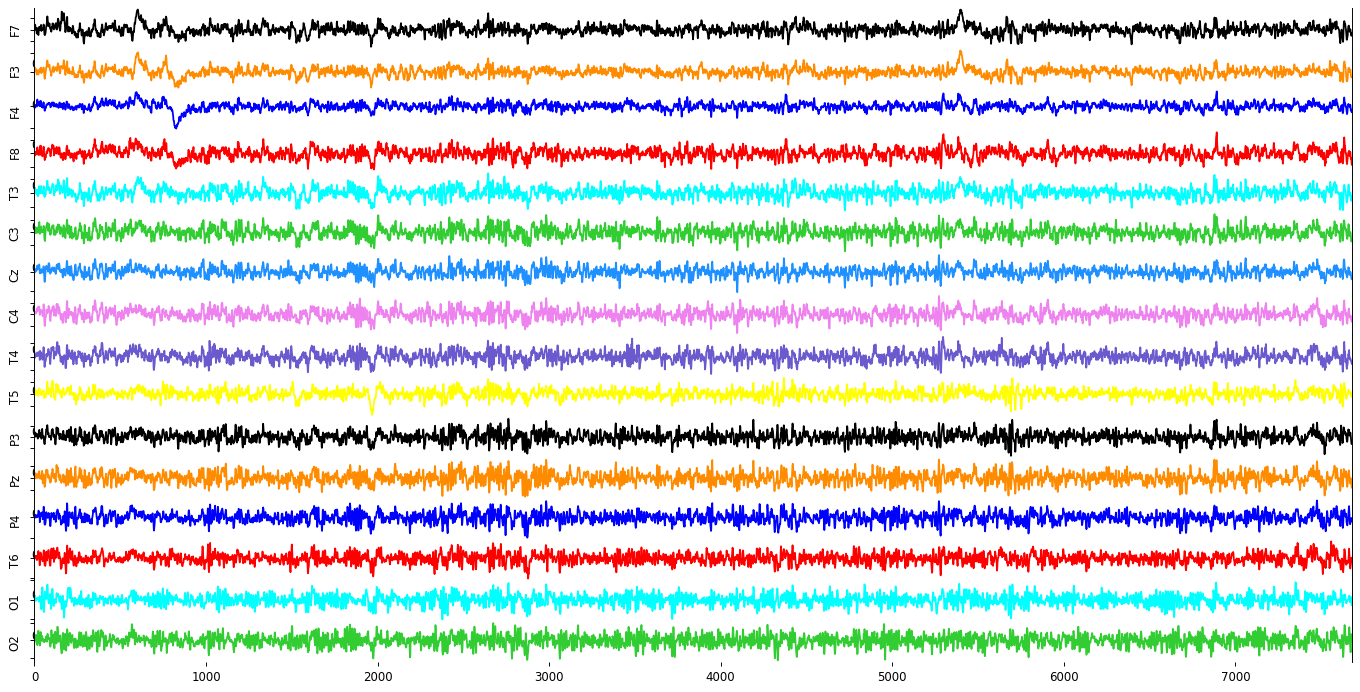

In [11]:
print("\n16-channel plot of one schizophrenic subject")
plot_signals(sch_data, 1)


16-channel plot of one healthy subject


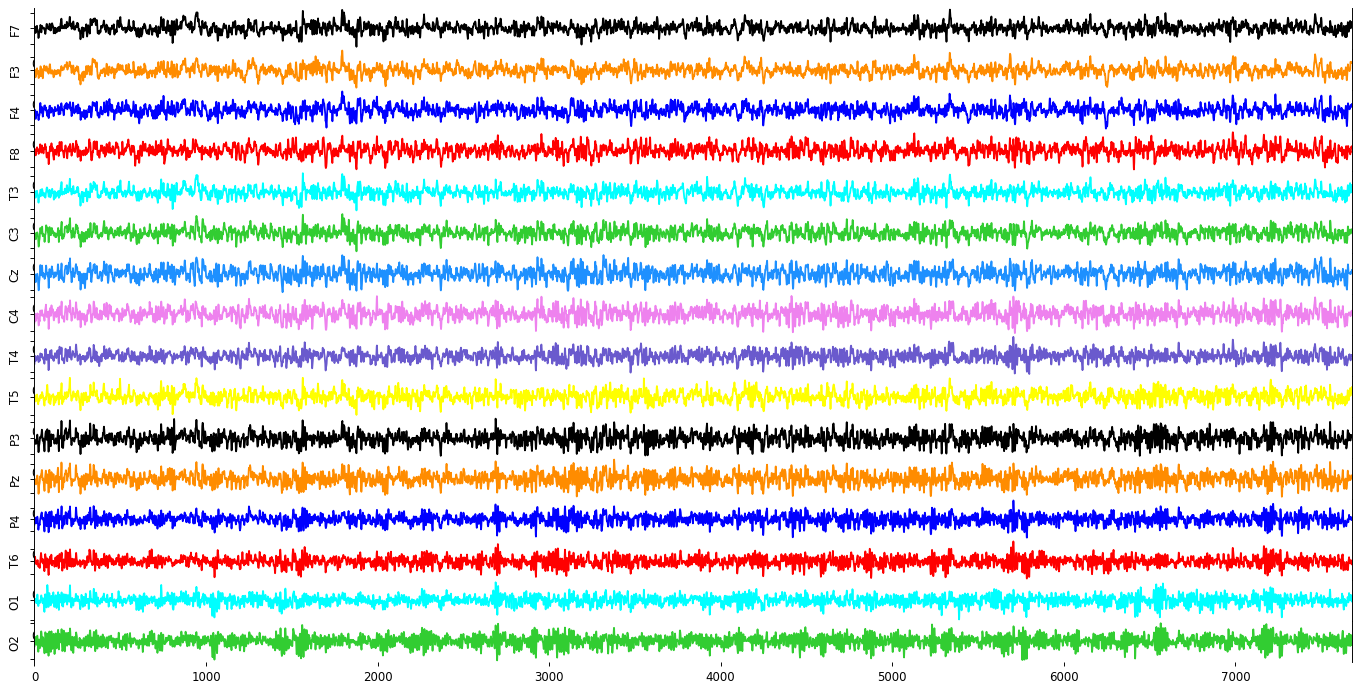

In [12]:
print("\n16-channel plot of one healthy subject")
plot_signals(norm_data, 2)

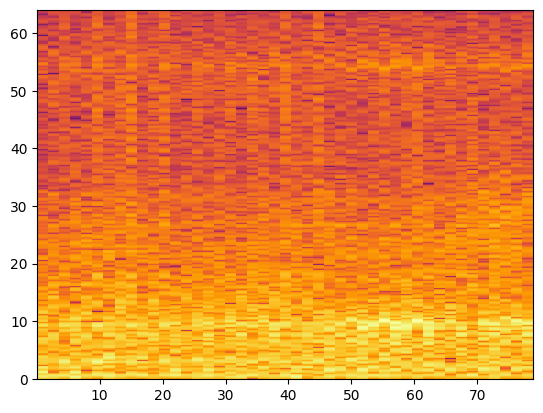

In [13]:
create_spectrogram(sch_specgram_data[0][0], fs=freq)

In [14]:
cwd = os.getcwd()
print(cwd)

/content/drive/MyDrive/Colab Notebooks/EEG_SHCEEEZ-DL


In [15]:
def generate_images_for_subject(path, subject_data, sub_index):
  for i, segment in enumerate(subject_data):
    filename = f'sub{sub_index}-seg{i}'
    print('generated: ', filename)
    create_spectrogram(segment, fs=freq, impath=os.path.join(path, filename), save=True)


def generate_images(data, path, start=0, end=0):
  if(end == 0 or end > len(data)):
    end = len(data)
  if not os.path.exists(os.path.join(cwd, path)):
    os.mkdir(path)
  for i in range(start, end):
    generate_images_for_subject(path, data[i], i)

In [16]:
images_path_f = os.path.join('out', 'F')

In [17]:
generate_images(sch_specgram_data, os.path.join(images_path_f, 'sch'), start=10, end=35)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
generate_images(norm_specgram_data, os.path.join(images_path_f, 'norm'), start=10, end=28)

Output hidden; open in https://colab.research.google.com to view.